In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pygsp as pg
from pygsp import plotting
from scipy.linalg import expm
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

We will try to do a simple example, let's take a delta for each node and evolve it with time

In [3]:
N = 5 # number of nodes for our graph
G = pg.graphs.Path(N) # create path graph with N nodes

Deltas are the columns here

In [4]:
H = np.eye(N)

Take third column and plot it

Text(0.5, 1.0, 'Signal at time t=0')

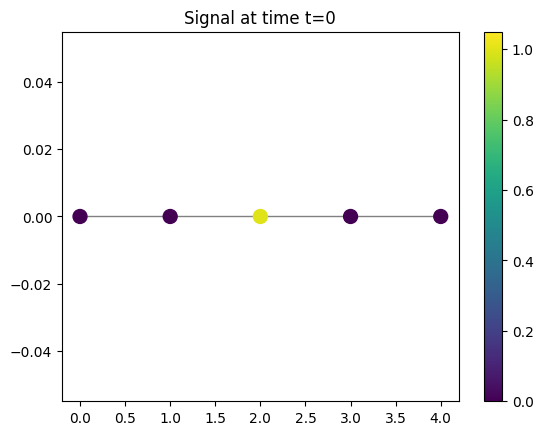

In [5]:
plotting.plot_signal(G,H[:,2])
plt.title("Signal at time t=0")

Let's evolve each signal $\tau=[1,2.5,4]$ units of time

Text(0.5, 1.0, 'Signal at rate 2.5, delta at the end')

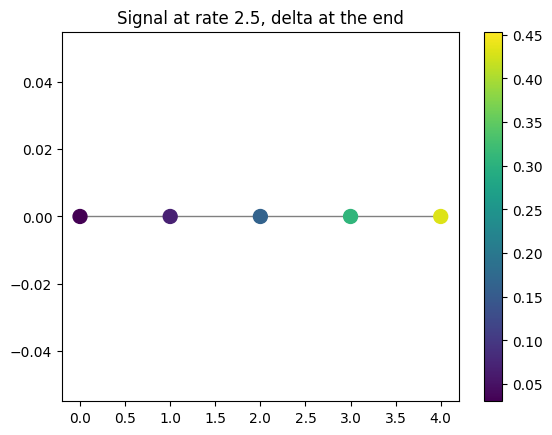

In [6]:
# extract the Laplacian from the line graph
L = G.L.toarray()
L = L/np.trace(L)*(L.shape[0])
# evolve the eye signal
signals = []
taus = [1,2.5,4]
for tau in taus:
    signals.append(expm(-tau*L)@H)
plotting.plot_signal(G,signals[1][:,4])
plt.title("Signal at rate 2.5, delta at the end")

Trying to learn from the diffused signal

In [28]:
import learnHeat as lh
# concatenate created signals
X = np.concatenate([signal for signal in signals], axis=1)
# create random graph and Laplacian
M = X.shape[1]

_, L0, H0, tau0 = lh.create_signal(N=N,tau_ground=[1,2,3],M=M,se=0.1)

In [29]:
L0

array([[ 2,  0,  0, -1, -1],
       [ 0,  1, -1,  0,  0],
       [ 0, -1,  2,  0, -1],
       [-1,  0,  0,  1,  0],
       [-1,  0, -1,  0,  2]])

In [30]:
X.shape[:],L.shape[:],H.shape[:],len(taus) # H shape is wrong

((5, 15), (5, 5), (5, 5), 3)

In [31]:
result = lh.learn_heat(X = X, 
                    L0=L, H0 = np.random.rand(15,15), tau0=[1,2,3], 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.0)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [32]:
result["L"]

array([[ 0.84497, -0.84497,  0.     ,  0.     ,  0.     ],
       [-0.84497,  1.10857, -0.2636 , -0.     ,  0.     ],
       [ 0.     , -0.2636 ,  0.41908, -0.15548,  0.     ],
       [ 0.     , -0.     , -0.15548,  1.39143, -1.23595],
       [ 0.     ,  0.     ,  0.     , -1.23595,  1.23595]])

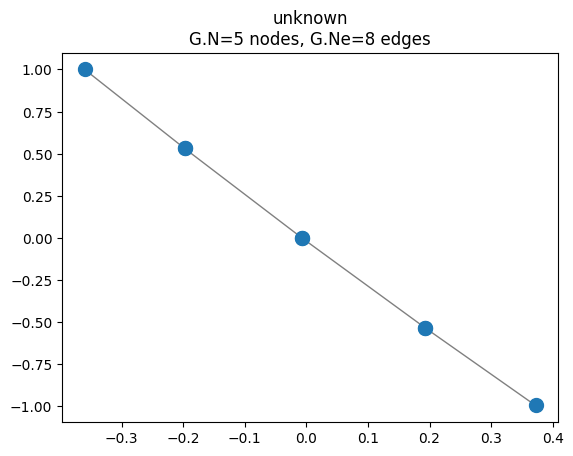

In [34]:
Lres = result["L"]
Lres[abs(Lres)<0.01] = 0
Adj = -np.copy(result["L"])
np.fill_diagonal(Adj, 0)
G_learned = pg.graphs.Graph(Adj)
G_learned.set_coordinates()
plotting.plot_graph(G_learned)

Now for the same graph, can we do the same technique with noise?

In [37]:
se = 0.1 # standard deviation
noisyX = X + se*np.random.randn(X.shape[0],X.shape[1])
noisy_result = lh.learn_heat(X = X, 
                    L0=L, H0 = np.random.rand(15,15), tau0=[1,2,3], 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.01)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

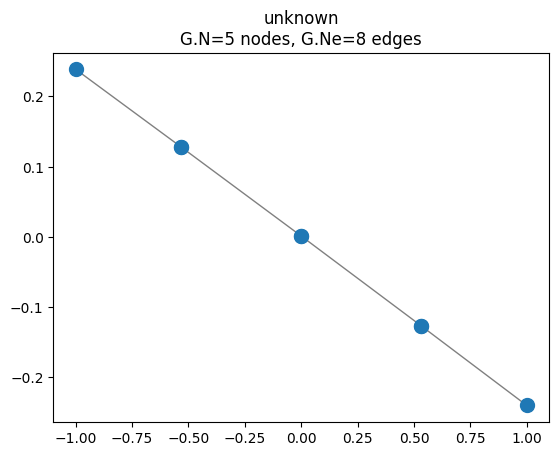

In [38]:
noisy_Lres = result["L"]
noisy_Lres[abs(Lres)<0.01] = 0
noisy_Adj = -np.copy(result["L"])
np.fill_diagonal(noisy_Adj, 0)
noisy_G_learned = pg.graphs.Graph(noisy_Adj)
noisy_G_learned.set_coordinates()
plotting.plot_graph(noisy_G_learned)